In [88]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -p numpy,sklearn,pandas
%watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
%watermark -p torch,torchvision,torchaudio
# %watermark -p tensorflow,tensorboard,tflite
# %watermark -p onnx,tf2onnx,onnxruntime,tensorrt,tvm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
# %config IPCompleter.use_jedi = False

# %matplotlib widget
# from IPython.display import display, Markdown, HTML, IFrame, Image, Javascript
# from IPython.core.magic import register_line_cell_magic, register_line_magic, register_cell_magic
# display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil
import argparse, shlex, signal
import numpy as np
import pyflann
import scipy.io as sio
import torch
import torchvision.transforms as transforms

from torchvision.utils import make_grid 


np.set_printoptions(
    edgeitems=3, infstr='inf',
    linewidth=75, nanstr='nan', precision=6,
    suppress=True, threshold=100, formatter=None)

argparse.ArgumentParser.exit = lambda *arg, **kwargs: _IGNORE_

def _IMPORT(x, tag='main', debug=False):
    def __request_text(url):
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        else:
            raise RuntimeError(url)
    try:
        x = x.strip()
        if x[0] == '/' or x[1] == '/':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                x = 'https://' + x
                x = __request_text(x)
            elif x.startswith('github.com'):
                x = x.replace('github.com', 'raw.githubusercontent.com')
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/{tag}/' + '/'.join(mod[-3:])
                x = __request_text(x)
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/raw/{tag}/' + '/'.join(mod[3:])
                x = __request_text(x)
        if debug:
            return x
        else:
            exec(x, globals())
    except Exception as err:
        # sys.stderr.write(f'request {x} : {err}')
       pass

def _DIR(x, dumps=True, ret=True):
    attrs = sorted([y for y in dir(x) if not y.startswith('_')])
    result = '%s: %s' % (str(type(x))[8:-2], json.dumps(attrs) if dumps else attrs)
    if ret:
        return result
    print(result)

_IMPORT('./easy_widget.py')

numpy  : 1.22.3
sklearn: 1.0.2
pandas : 1.4.1

ipywidgets: 7.7.1
cv2       : 4.8.1
PIL       : 9.0.1
matplotlib: 3.5.1
plotly    : 5.18.0
netron    : not installed

torch      : 1.12.0.dev20220327+cpu
torchvision: 0.13.0.dev20220327+cpu
torchaudio : 0.12.0.dev20220327+cpu



In [52]:

###
### Display ###
###

_IMPORT('import pandas as pd')
_IMPORT('import cv2')
_IMPORT('from PIL import Image')
_IMPORT('import matplotlib.pyplot as plt')
_IMPORT('import plotly')
_IMPORT('import plotly.graph_objects as go')
_IMPORT('import ipywidgets as widgets')
_IMPORT('from ipywidgets import interact, interactive, fixed, interact_manual')

# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)
# from matplotlib.font_manager import FontProperties
# simsun = FontProperties(fname='/sysfonts/simsun.ttc', size=12)


def _imread(imgin):
    is_bytes = isinstance(imgin, bytes)
    if is_bytes or imgin.startswith('http'):
        if not is_bytes:
            response = requests.get(imgin)
            if response:
                imgin = response.content
            else:
                raise
        img = cv2.imdecode(np.frombuffer(imgin, dtype=np.uint8), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    else:
        img = cv2.imread(imgin)
    return img

def _imshow(image, title=None, color='bgr', figsize=(6, 3), canvas=False):
    import IPython
    plt.close('all')
    if figsize == 'auto':
        ih, iw = image.shape[:2]
        fw, fh = int(1.5 * iw / 80) + 1, int(1.5 * ih / 80) + 1
        if fw > 32:
            fh = int(32 * (fh / fw))
            fw = 32
        figsize = (fw, fh)
    if canvas:
        IPython.get_ipython().enable_matplotlib(gui='widget');
        fig = plt.figure(figsize=figsize)
        fig.canvas.toolbar_position = 'left'
        fig.canvas.toolbar_visible = True
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = True
    else:
        IPython.get_ipython().enable_matplotlib(gui='inline')
        fig = plt.figure(figsize=figsize)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    if color == 'gray' or len(image.shape) == 2:
        plt.imshow(image, cmap='gray');
    else:
        if color == 'bgr':
           image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image);
        
def _imgrid(images, nrow=None, padding=4, pad_value=127, labels=None,
                     font_scale=1.0, font_thickness=1, text_color=(255,), text_color_bg=None):
    count = len(images)
    if isinstance(images, dict):
        labels = [lab for lab in images.keys()]
        images = [img for img in images.values()]

    if not isinstance(images, (list, tuple, np.ndarray)) or count == 0 or not isinstance(images[0], np.ndarray):
        return
    if nrow is None or nrow > count:
        nrow = count

    max_h, max_w = np.asarray([img.shape[:2] for img in images]).max(axis=0)
    if labels is not None:
        text_org = int(0.1 * max_w), int(0.9 * max_h)
        shape_length = 3
    else:
        shape_length = np.asarray([len(img.shape) for img in images]).max()
    lack = count % nrow
    rows = np.int0(np.ceil(count / nrow))
    hpad_size = [max_h, padding] 
    if rows > 1:
        vpad_size = [padding, nrow * max_w + (nrow - 1) * padding]
        if lack > 0:
            lack_size = [max_h, max_w]
    if shape_length == 3:
        hpad_size.append(3)
        if rows > 1:
            vpad_size.append(3)
            if lack > 0:
                lack_size.append(3)
    hpadding = pad_value * np.ones(hpad_size, dtype=np.uint8)
    if rows > 1:
        vpadding = pad_value * np.ones(vpad_size, dtype=np.uint8)
        if lack > 0:
            lack_image = pad_value * np.ones(lack_size, dtype=np.uint8)
            images.extend([lack_image] * lack)
            if labels is not None:
                labels.extend([''] * lack)
    vlist = []
    for i in range(rows):
        hlist = []
        for j in range(nrow):
            if j != 0:
                hlist.append(hpadding)
            timg = images[i * nrow + j].copy()
            th, tw = timg.shape[:2]
            if th != max_h or tw != max_w:
                timg = cv2.resize(timg, (max_w, max_h))
            if len(timg.shape) != shape_length:
                timg = cv2.cvtColor(timg, cv2.COLOR_GRAY2BGR)
            if labels is not None:
                text = str(labels[i * nrow + j])
                if len(text) > 0:
                    if text_color_bg is not None:
                        (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
                        pos1 = text_org[0] - int(font_scale * 5), text_org[1] - th - int(font_scale * 5)
                        pos2 = text_org[0] + int(font_scale * 5) + tw, text_org[1] + int(font_scale * 8)
                        cv2.rectangle(timg, pos1, pos2, text_color_bg, -1)
                    cv2.putText(timg, text, text_org, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness)
            hlist.append(timg)
        if i != 0:
            vlist.append(vpadding)
        vlist.append(np.hstack(hlist))
    if rows > 1:
        return np.vstack(vlist)
    return vlist[0]


## Global Variables and Functions

In [142]:
TOP_DIR='/jupyter/hzcsbet/gamebet'
CKPTS_DIR = f'{TOP_DIR}/checkpoints'
HEIGHT, WIDTH = 720, 1280
yard2meter = 0.9144
template_h, template_w = int(74 * yard2meter) + 2, int(115 * yard2meter) + 2
interpolation = cv2.INTER_AREA

sys.path.append(TOP_DIR)
    
if not os.path.isdir(CKPTS_DIR):
    raise '!!! network weights !!!'
    
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:{}'.format(args.cuda_id))
    cudnn.benchmark = True

seg_G_weights_path = f'{CKPTS_DIR}/seg_G.pth'
det_G_weights_path = f'{CKPTS_DIR}/det_G.pth'
siamese_weights_path = f'{CKPTS_DIR}/siamese.pth'
feature_database_path = f'{TOP_DIR}/data/features_database_20000_ori.mat'
pyflann.set_distance_type(distance_type='euclidean')
flann = pyflann.FLANN()
features_data = None
    
video_url_prefix = 'https://gamebet-1301930378.cos.ap-beijing.myqcloud.com/dfl-bundesliga-data-shootout/test'
video_mp4_files = [
    '019d5b34_1.mp4',
    '947e05ca_1.mp4',
    '9d3c239b_1.mp4',
    'e9d974aa_0.mp4',
    'ef4c2eb9_1.mp4',
]

image_url_prefix = 'https://gamebet-1301930378.cos.ap-beijing.myqcloud.com/soccer_data/test'
image_jpg_files = [ f'{idx}.jpg' for idx in range(1, 187) ]

## Load Network

In [100]:
from models.networks import define_G
from models.siamese import SiameseNetwork
from util.camera import CameraPose, CameraProp, PerspectiveCamera

###  Seg Generate Net

In [5]:
seg_G_net = define_G(input_nc=3, output_nc=1, ngf=64, netG='unet_256')
state_dict = torch.load(seg_G_weights_path, map_location=device)
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
seg_G_net.load_state_dict(state_dict)
seg_G_net.to(device);

initialize network with normal


### Det Generate Net

In [6]:
det_G_net = define_G(input_nc=3, output_nc=1, ngf=64, netG='unet_256')
state_dict = torch.load(det_G_weights_path, map_location=device)
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
det_G_net.load_state_dict(state_dict)
det_G_net.to(device);

initialize network with normal


### Siamese Net

In [51]:
siamese_net = SiameseNetwork()
state_dict = torch.load(siamese_weights_path, map_location=device)
siamese_net.load_state_dict(state_dict['model'])
siamese_net.to(device);

## Test

In [15]:
seg_det_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

siamese_transform = transforms.Compose([
    transforms.Resize((180, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.01852269, std=0.11619838)
])

In [131]:
def birdeye_perspective_transform(img_raw, seg_net, det_net, sia_net, seg_det_transform, siamese_transform, flann, features_db):
    img_raw = cv2.resize(img_raw, (1280, 720))
    result = {'phase1': {'x': img_raw}, 'phase2': {}}
    image_input = torch.unsqueeze(seg_det_transform(Image.fromarray(img_raw)), 0)
    seg_net.eval(); det_net.eval(); sia_net.eval() 
    
    def _tensor2im(image_tensor):
        image_numpy = image_tensor[0].cpu().float().numpy()
        if image_numpy.shape[0] == 1:
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0   
        return image_numpy.astype(np.uint8)
    
    def _warp_perspective(h_templ2cam, img_cam, img_size, scale=1, bg=0):
        # template view (0, 0) at top-left, so v-flip transform 
        trans = np.array([
            [1, 0, 0],
            [0, -1, img_size[1]],
            [0, 0, 1],
        ])
        if scale > 1:
            trans = np.array([
                [scale, 0, 0],
                [0, scale, 0],
                [0, 0, 1]
            ]) @ trans
            h_cam2templ = np.linalg.inv(h_templ2cam)
            return cv2.warpPerspective(img_cam, trans @ h_cam2templ, (scale * img_size[0], scale * img_size[1]), borderMode=cv2.BORDER_CONSTANT, borderValue=bg)
    
    with torch.no_grad():
        seg_mask = seg_net(image_input)
        result['phase1']['seg_mask'] = _tensor2im(seg_mask.data)
        
        fake = (seg_mask + 1.0) / 2.0       # [0, 1]
        real = (image_input + 1.0) / 2.0    # [0, 1]
        det_mask = (fake * real) * 2.0 - 1  # [-1, 1]
        result['phase1']['det_mask'] = _tensor2im(det_mask.data)
        
        det_edge = _tensor2im(det_G_net(det_mask))
        result['phase1']['det_edge'] = det_edge.copy() # _tensor2im(det_edge.data)
        
        img_edge = cv2.resize(cv2.cvtColor(det_edge, cv2.COLOR_RGB2GRAY), (320, 180), interpolation=cv2.INTER_AREA)
        sia_input = torch.unsqueeze(siamese_transform(Image.fromarray(img_edge)), 0)
        features = sia_net._forward_once(sia_input).cpu().numpy().squeeze()
        
    template_w, template_h = 107, 69
    nbrs, dists = flann.nn_index(features, 1)
    camera_data = features_db['cameras'][nbrs[0]]
    prop = CameraProp(cx=camera_data[0], cy=camera_data[1], fl=camera_data[2])
    pose = CameraPose.from_axis_angle(camera_data[3:6], camera_data[6:9])
    camera = PerspectiveCamera(prop, pose)
    
    img_edge_src = cv2.resize(features_db['images'][nbrs[0]], (1280, 720))
    img_edge_dst = cv2.resize(img_edge, (1280, 720))
    img_edge_search = cv2.threshold(img_edge_src, 10, 255, cv2.THRESH_BINARY_INV)[1]
    img_edge_detect = cv2.threshold(img_edge_dst, 10, 255, cv2.THRESH_BINARY_INV)[1]
    
    img_search_dist = cv2.distanceTransform(img_edge_search, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    img_detect_dist = cv2.distanceTransform(img_edge_detect, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    dist_threshold = 50
    img_search_dist[img_search_dist > dist_threshold] = dist_threshold
    img_detect_dist[img_detect_dist > dist_threshold] = dist_threshold
    
    homo = camera.get_homography()
    result['phase2']['dist: %.6f' % dists[0]] = img_edge_src
    result['phase2']['search_dist'] = cv2.normalize(img_search_dist, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)
    result['phase2']['detect_dist'] = cv2.normalize(img_detect_dist, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)
    result['phase2']['homo_origin'] = _warp_perspective(homo, img_raw, (template_w, template_h), scale=10)
        
    hrefine = np.eye(3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.001)
    try:
        hrefine = cv2.findTransformECC(img_search_dist, img_detect_dist, hrefine, cv2.MOTION_HOMOGRAPHY, criteria, None, 5)[1]
    except Exception:
        pass
    result['phase2']['homo_refine'] = _warp_perspective(hrefine @ homo, img_raw, (template_w, template_h), scale=10)
    result['ann_dist'] = dists[0]
    
    return result

In [146]:
w_video, w_image = nbeasy_show_video(f'{video_url_prefix}/{video_mp4_files[4]}', width=960, height=540)

Box(children=(Box(children=(VBox(children=(HBox(children=(VBox(children=(VideoE(value=b'https://gamebet-130193…

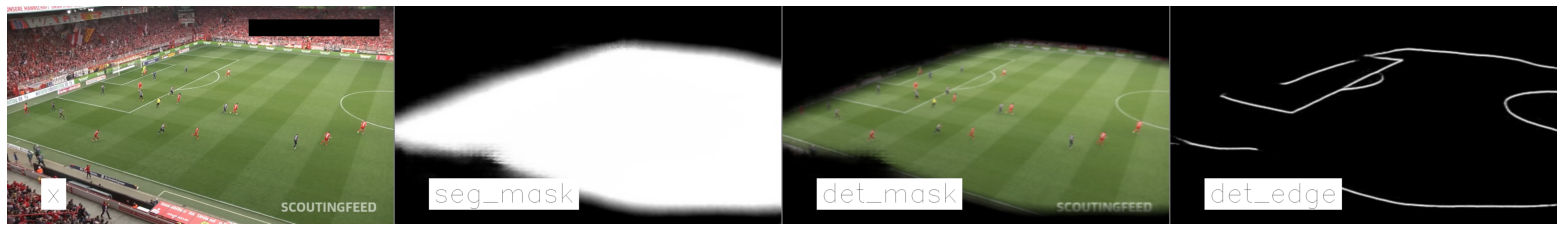

In [147]:
if features_data is None and os.path.exists(feature_database_path):
    features_data = sio.loadmat(feature_database_path)
    flann.build_index(features_data['features'], algorithm='kdtree', trees=8, checks=64)

result = birdeye_perspective_transform(
    _imread(w_image.value),
    seg_G_net, det_G_net, siamese_net,
    seg_det_transform, siamese_transform,
    flann, features_data
)

_imshow(_imgrid(result['phase1'], font_scale=3.0, text_color=(0,), text_color_bg=(255, 255, 255)), color='rgb', figsize='auto')

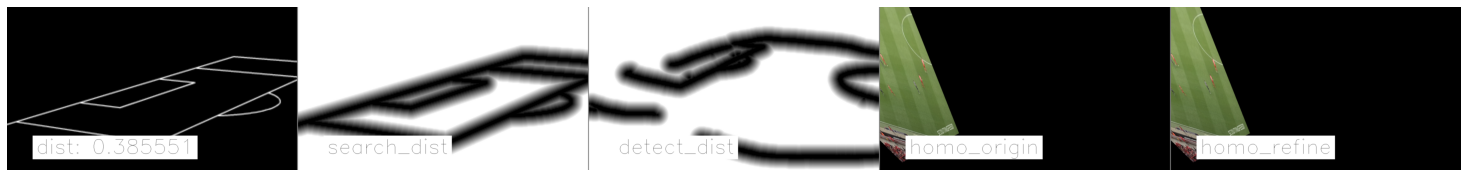

In [148]:
_imshow(_imgrid(result['phase2'], font_scale=3.0,  text_color=(0,), text_color_bg=(255, 255, 255)), color='rgb', figsize='auto')